<a href="https://colab.research.google.com/github/Mainakdeb/eyes-on-the-road/blob/master/train-motor-sentinel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
! pip install Augmentor

In [0]:
import pandas as pd
import shutil
from tqdm.notebook import tnrange, tqdm
import Augmentor
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [0]:
torch.cuda.is_available()

True

In [3]:
drive_csv_path='/content/drive/My Drive/driver_imgs_list.csv'
local_csv_path='./state-farm-distracted-driver-detection/driver_imgs_list.csv'
df=pd.read_csv(drive_csv_path)
print(df.info())
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22424 entries, 0 to 22423
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subject    22424 non-null  object
 1   classname  22424 non-null  object
 2   img        22424 non-null  object
dtypes: object(3)
memory usage: 525.7+ KB
None


,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg
...,...,...,...
22419,p081,c9,img_56936.jpg
22420,p081,c9,img_46218.jpg
22421,p081,c9,img_25946.jpg
22422,p081,c9,img_67850.jpg


## Classes
* c0: safe driving
* c1: texting - right
* c2: talking on the phone - right
* c3: texting - left
* c4: talking on the phone - left
* c5: operating the radio
* c6: drinking
* c7: reaching behind
* c8: hair and makeup
* c9: talking to passenger



In [0]:
print(df["classname"].value_counts())

c0    2489
c3    2346
c4    2326
c6    2325
c2    2317
c5    2312
c1    2267
c9    2129
c7    2002
c8    1911
Name: classname, dtype: int64


In [0]:
## 0 = safe, 1 = unsafe

df2=df
unsafe_classes=['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
df2.loc[(df.classname == 'c0'),'classname']=0

for u in unsafe_classes:
    df2.loc[(df.classname == u),'classname']=1
    
print(df["classname"].value_counts())
df.head()

1    19935
0     2489
Name: classname, dtype: int64


,subject,classname,img
0,p002,0,img_44733.jpg
1,p002,0,img_72999.jpg
2,p002,0,img_25094.jpg
3,p002,0,img_69092.jpg
4,p002,0,img_92629.jpg


In [0]:
big_dictionary = dict(df["classname"].value_counts())
print(big_dictionary)

{1: 19935, 0: 2489}


In [0]:
! mkdir ./state-farm-distracted-driver-detection/imgs/train/0   
! mv ./state-farm-distracted-driver-detection/imgs/train/c0/*.jpg  ./state-farm-distracted-driver-detection/imgs/train/0

! mkdir ./state-farm-distracted-driver-detection/imgs/train/1
! mv ./state-farm-distracted-driver-detection/imgs/train/c1/*.jpg  ./state-farm-distracted-driver-detection/imgs/train/1/
! mv ./state-farm-distracted-driver-detection/imgs/train/c2/*.jpg  ./state-farm-distracted-driver-detection/imgs/train/1/
! mv ./state-farm-distracted-driver-detection/imgs/train/c3/*.jpg  ./state-farm-distracted-driver-detection/imgs/train/1/
! mv ./state-farm-distracted-driver-detection/imgs/train/c4/*.jpg  ./state-farm-distracted-driver-detection/imgs/train/1/
! mv ./state-farm-distracted-driver-detection/imgs/train/c5/*.jpg  ./state-farm-distracted-driver-detection/imgs/train/1/
! mv ./state-farm-distracted-driver-detection/imgs/train/c6/*.jpg  ./state-farm-distracted-driver-detection/imgs/train/1/
! mv ./state-farm-distracted-driver-detection/imgs/train/c7/*.jpg  ./state-farm-distracted-driver-detection/imgs/train/1/
! mv ./state-farm-distracted-driver-detection/imgs/train/c8/*.jpg  ./state-farm-distracted-driver-detection/imgs/train/1/
! mv ./state-farm-distracted-driver-detection/imgs/train/c9/*.jpg  ./state-farm-distracted-driver-detection/imgs/train/1/

! rm -d ./state-farm-distracted-driver-detection/imgs/train/c0
! rm -d ./state-farm-distracted-driver-detection/imgs/train/c1
! rm -d ./state-farm-distracted-driver-detection/imgs/train/c2
! rm -d ./state-farm-distracted-driver-detection/imgs/train/c2
! rm -d ./state-farm-distracted-driver-detection/imgs/train/c3
! rm -d ./state-farm-distracted-driver-detection/imgs/train/c4
! rm -d ./state-farm-distracted-driver-detection/imgs/train/c5
! rm -d ./state-farm-distracted-driver-detection/imgs/train/c6
! rm -d ./state-farm-distracted-driver-detection/imgs/train/c7
! rm -d ./state-farm-distracted-driver-detection/imgs/train/c8
! rm -d ./state-farm-distracted-driver-detection/imgs/train/c9

In [0]:

# oversample minority classes using Augmentor
def img_oversampler_from_df(df, classname, rootdir): 
    
    big_dictionary = dict(df[classname].value_counts())
    class_bois= list(big_dictionary.keys())
    val_bois= list(big_dictionary.values())
    
    for i in tnrange(len(class_bois)):
    
        p = Augmentor.Pipeline(rootdir+"/"+str(class_bois[i])+"/")
        p.rotate(probability=1, max_left_rotation=7, max_right_rotation=7)
        p.zoom_random(probability=0.9, percentage_area=0.95)
        p.crop_random(probability=1, percentage_area=0.95)

        if max(val_bois)-val_bois[i] == 0:
            pass
        else:
            p.sample(max(val_bois)-val_bois[i])
            
        #print(rootdir+"/"+class_bois[i]+"/", max(val_bois)-val_bois[i])

In [0]:
img_oversampler_from_df(df, 'classname', './state-farm-distracted-driver-detection/imgs/train')

In [0]:
! mv ./state-farm-distracted-driver-detection/imgs/train/0/output/*.jpg  ./state-farm-distracted-driver-detection/imgs/train/0

In [0]:
! find ./state-farm-distracted-driver-detection/imgs/train/0/output -name '*.*' -exec mv {} ./state-farm-distracted-driver-detection/imgs/train/0 \;

In [0]:
! rm -d ./state-farm-distracted-driver-detection/imgs/train/0/output

In [5]:
#unzip tar.xz in content
%%bash 
mkdir foldername
tar -xvf '/content/drive/My Drive/state-farm-distracted-driver-detection.tar.xz' -C '/content/'

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
p = Augmentor.Pipeline()
p.rotate(probability=1, max_left_rotation=3, max_right_rotation=3)
p.zoom_random(probability=0.9, percentage_area=0.99)
p.crop_random(probability=1, percentage_area=0.99)
p.random_distortion(probability=1, grid_width=4, grid_height=4, magnitude=1)

transformations_n = transforms.Compose([
    p.torch_transform(),
    transforms.Resize((150,150), interpolation=2),
    transforms.ToTensor(),
])

In [57]:
drive_train_path='/content/state-farm-distracted-driver-detection/imgs/train'
local_train_path='./state-farm-distracted-driver-detection/imgs/train'
data = torchvision.datasets.ImageFolder(root=drive_train_path, transform=transformations_n)
print(len(data))
train_set, val_set = torch.utils.data.random_split(data, [len(data)-2000, 2000])

39870


Label: 0


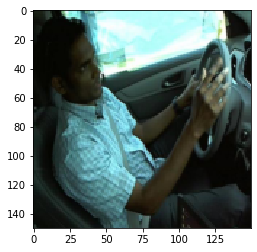

In [58]:
train_set, val_set = torch.utils.data.random_split(data, [len(data)-2000, 2000])
sample = next(iter(train_set))
image,label = sample 
x=np.transpose(image, (1, 2, 0))
plt.imshow(x, interpolation='none')
print("Label:", label)

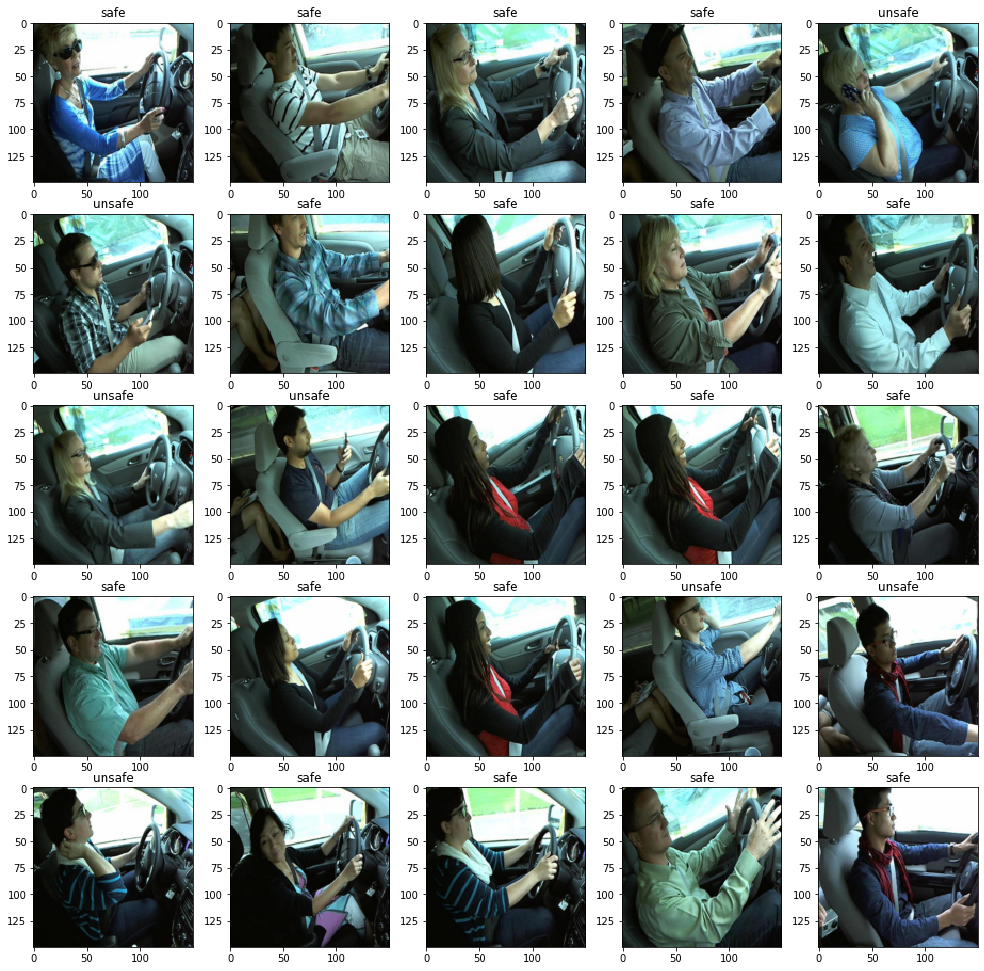

<Figure size 720x216 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

In [59]:
train_loader_1 = torch.utils.data.DataLoader(
    train_set
    ,batch_size=1
    ,shuffle=True
)

class_list = ['safe', 'unsafe']

fig, axs = plt.subplots(5, 5, figsize=(17,17))
fig = plt.figure(figsize=(10,3))
trans = transforms.ToPILImage()
plt.figure(figsize=(50,50))

for i in range(5):
    for j in range(5):
        for image_list in (train_loader_1):
            np_image=image_list[0][0]
            label_tensor=image_list[1][0]
            max_index = (label_tensor.item())
            label_ = class_list[max_index]
            
            image=np_image
            x=np.transpose(image, (1, 2, 0))

            axs[j,i].imshow(x, interpolation='none')
            axs[j,i].title.set_text(label_)
            break
plt.show()

# The Skin filter:

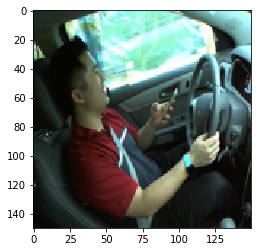

Label: 1


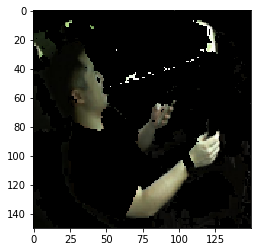

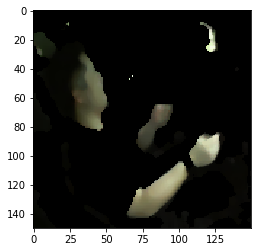

In [64]:
import cv2
import numpy as np

train_set, val_set = torch.utils.data.random_split(data, [len(data)-2000, 2000])
sample = next(iter(train_set))
image,label = sample 
x=np.transpose(image, (1, 2, 0))
plt.imshow(x, interpolation='none')
plt.show()
print("Label:", label)


#HSV filter
lower_red=np.array([140,0,0])
upper_red=np.array([210,1,100])
hsv=cv2.cvtColor(np.float32(x), cv2.COLOR_BGR2HSV)
mask=cv2.inRange(hsv, lower_red, upper_red)
res=cv2.bitwise_and(np.float32(x),np.float32(x), mask=mask)
plt.imshow(res, interpolation='none')
plt.show()


#de-noise
median = cv2.medianBlur(res,5) # works
plt.imshow(np.float32(median), interpolation='none')
plt.show()

# opening = cv2.morphologyEx(median, cv2.MORPH_OPEN,(5,5))
# plt.imshow(np.float32(opening), interpolation='none')
# plt.show()

In [0]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 7)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*34*34, 500)
        self.fc2 = nn.Linear(500, 50)
        self.fc3 = nn.Linear(50, 2)

        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        #print(x.shape)
        x = x.view(-1, 16*34*34)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

        

network=Net()
network=network.cuda()

In [0]:
train_loader_2 = torch.utils.data.DataLoader(
    train_set
    ,batch_size=128
    ,shuffle=True
    ,num_workers=8
    ,pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    val_set, 
    batch_size=500, 
    shuffle=True
)

loss_list=[]
acc_list=[]
val_loss_list=[]
val_acc_list=[]


optimizer = optim.Adam(network.parameters(), lr=0.0008)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=4)

In [0]:
for epoch in tnrange(3):
    
    total_loss = 0
    total_correct = 0
    total_loss2 = 0
    total_correct2 = 0

    for batch in tqdm(train_loader_2): # Get Batch

        images, labels = batch
        images=images.cuda()
        labels=labels.cuda()
        preds = network(images) # Pass Batch        
        loss = F.cross_entropy(preds, labels) # Calculate Loss
        
        optimizer.zero_grad()
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)
        
    with torch.no_grad():
        network.eval()
        for batch2 in (val_loader): # Get Batch

            images2, labels2 = batch2
            images2=images2.cuda()
            labels2=labels2.cuda()
      
            preds2 = network(images2) # Pass Batch
            loss2 = F.cross_entropy(preds2, labels2)

            total_loss2 += loss2.item()
            total_correct2 += get_num_correct(preds2, labels2)

    loss_list.append(total_loss/(39870-2000))
    acc_list.append(total_correct/(39870-2000))
    val_loss_list.append(total_loss2/2000)
    val_acc_list.append(total_correct2/2000)